# Proyek Klasifikasi Gambar: Beras
- **Nama:** Faizah Rizki Auliawati
- **Email:** frauliawati@gmail.com
- **ID Dicoding:** MC009D5X2457



###**Dataset source:**
https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data

## Import Semua Packages/Library yang Digunakan

In [39]:
# Import Modul Standar
import os                  # Operasi sistem file dan direktori
import io                  # Operasi I/O (misalnya manipulasi buffer)
import zipfile             # Membuat dan membaca file zip
import random              # Operasi acak
import shutil              # Operasi file dan direktori (copy, move, dll.)

# Manipulasi Gambar
import cv2                 # OpenCV: manipulasi citra dan video
import numpy as np         # Operasi array numerik
import pandas as pd        # Manipulasi data tabular
import matplotlib.pyplot as plt       # Visualisasi data (plot)
import matplotlib.image as mpimg      # Membaca gambar untuk matplotlib
import seaborn as sns      # Visualisasi data lanjutan
from PIL import Image      # Image processing (dari Pillow)

# Scikit-learn: Evaluasi & Preprocessing
from sklearn.model_selection import train_test_split  # Membagi data training/testing
from sklearn.utils.class_weight import compute_class_weight  # Menyeimbangkan bobot kelas
from sklearn.metrics import (
    classification_report,     # Ringkasan metrik klasifikasi
    confusion_matrix,          # Matriks kebingungan
    accuracy_score             # Akurasi prediksi
)

# TensorFlow & Keras: Deep Learning
!pip install tensorflowjs
import tensorflow as tf
import tensorflowjs as tfjs   # Untuk ekspor model ke format web (TensorFlow.js)

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    InputLayer, Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Layer CNN umum
)
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, NumpyArrayIterator  # Augmentasi dan generator gambar
)
from tensorflow.keras.callbacks import (
    Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # Callback training
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16  # Pretrained model (opsional)

# PyTorch (jika ingin bandingkan atau gunakan model Torch)
import torch
from torchvision import datasets, transforms   # Dataset dan transformasi PyTorch
from torch.utils.data import DataLoader        # Loader data PyTorch


## Data Preparation

### Data Loading

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"faizahrizki","key":"8a06901f213f7a2c8142b19a11a95e02"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset
!unzip -q "rice-image-dataset.zip"

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0


In [6]:
dataset_path = "Rice_Image_Dataset"
print(os.listdir(dataset_path))

['Rice_Citation_Request.txt', 'Jasmine', 'Ipsala', 'Basmati', 'Arborio', 'Karacadag']


In [7]:
# Buat folder baru
os.makedirs('Rice_Image_Folders', exist_ok=True)

for folder in ['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']:
    shutil.move(os.path.join('Rice_Image_Dataset', folder), 'Rice_Image_Folders')

In [8]:
def print_images_resolution(directory):
    total_images = 0

    for subdir, _, files in os.walk(directory):
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
        num_images = len(image_files)

        if num_images > 0:
            unique_sizes = set()
            rel_path = os.path.relpath(subdir, directory)
            print(f"{rel_path}: {num_images} image(s)")
            total_images += num_images

            for img_file in image_files:
                img_path = os.path.join(subdir, img_file)
                try:
                    with Image.open(img_path) as img:
                        unique_sizes.add(img.size)
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

            for size in unique_sizes:
                print(f"  - Size: {size}")

            print("---------------")

    print(f"\nTotal images: {total_images}")


In [9]:
print_images_resolution('Rice_Image_Folders')

Jasmine: 15000 image(s)
  - Size: (250, 250)
---------------
Ipsala: 15000 image(s)
  - Size: (250, 250)
---------------
Basmati: 15000 image(s)
  - Size: (250, 250)
---------------
Arborio: 15000 image(s)
  - Size: (250, 250)
---------------
Karacadag: 15000 image(s)
  - Size: (250, 250)
---------------

Total images: 75000


### Data Preprocessing

#### Split Dataset

In [10]:
# Folder asal dan folder tujuan
source_dir = 'Rice_Image_Folders'
target_dir = 'Rice_Sampled'
os.makedirs(target_dir, exist_ok=True)

# Banyak gambar per kelas
images_per_class = 3000

# Loop setiap kelas
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        # Folder tujuan per kelas
        target_class_path = os.path.join(target_dir, class_name)
        os.makedirs(target_class_path, exist_ok=True)

        # List semua file gambar
        image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        # Acak dan pilih 3000 file
        selected_files = random.sample(image_files, images_per_class)

        # Salin file ke folder baru
        for file_name in selected_files:
            src_file = os.path.join(class_path, file_name)
            dst_file = os.path.join(target_class_path, file_name)
            shutil.copy2(src_file, dst_file)

print("Sampling selesai! Sekarang folder Rice_Sampled berisi 15.000 gambar.")


Sampling selesai! Sekarang folder Rice_Sampled berisi 15.000 gambar.


Total images in dataset: 15000


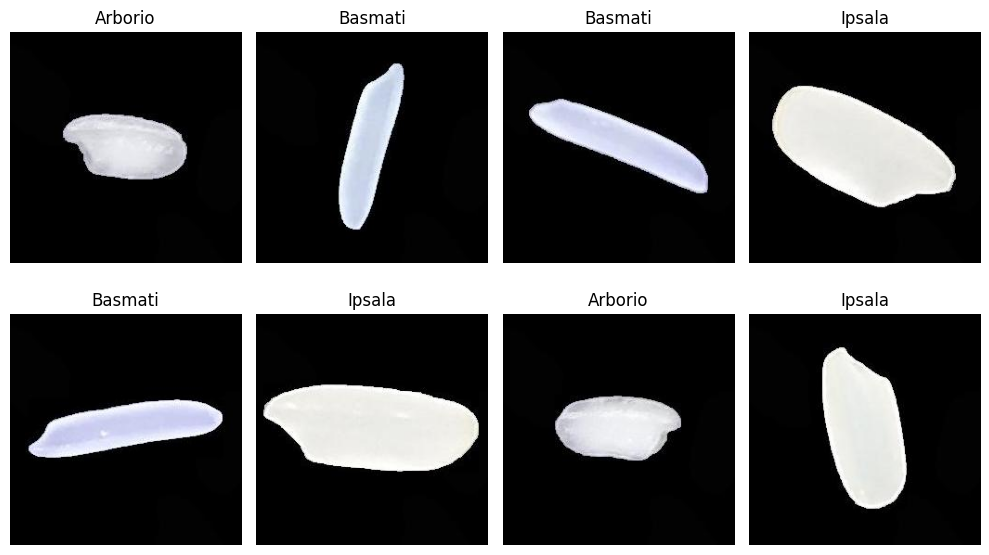

In [11]:
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor()
])

image_dataset = datasets.ImageFolder('Rice_Sampled', transform=transform)

print(f"Total images in dataset: {len(image_dataset)}")

def show_images(dataset, indices, rows=2, cols=4):

    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))
    axes = axes.flatten()

    valid_indices = [index for index in indices if index < len(dataset)]

    if not valid_indices:
        print("No valid indices found!")
        return

    for i, index in enumerate(valid_indices):
        if i < len(valid_indices) and i < rows * cols:  # Check bounds
            image, label = dataset[index]
            ax = axes[i]
            ax.imshow(image.permute(1, 2, 0))  # Correct permute order
            ax.set_title(dataset.classes[label])  # Set title
            ax.set_xlabel(f'Index: {index}')  # Set index as label
            ax.axis('off')  # Hide axis

    plt.tight_layout()
    plt.show()

image_list = [0, 3000, 3500, 8000, 5000, 6000, 3, 7000]

show_images(image_dataset, image_list)

In [12]:
# Tentukan rasio split
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Tentukan total rasio untuk validation + test
val_test_split = val_ratio + test_ratio

# Inisialisasi ImageDataGenerator untuk rescaling dan data splitting
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=val_test_split  # Gunakan validation_split untuk membagi data
)

# Membuat generator untuk training
train_generator = datagen.flow_from_directory(
    'Rice_Sampled',  # Gunakan dataset yang sudah disampling
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Hanya untuk training subset
    shuffle=True,
    seed=42
)

# Membuat generator untuk validation dan test (pembagian otomatis)
val_test_generator = datagen.flow_from_directory(
    'Rice_Sampled',  # Gunakan dataset yang sudah disampling
    target_size=(250, 250),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Hanya untuk validation subset
    shuffle=False,  # Tidak perlu shuffle untuk validation/test
    seed=42
)

# Verifikasi ukuran dataset
print("Training data shape:", train_generator.samples)
print("Validation and Testing data shape:", val_test_generator.samples)

# Membuat generator untuk validation dan test
val_generator = val_test_generator  # Gunakan generator yang sudah ada
test_generator = val_test_generator  # Gunakan generator yang sama

# Verifikasi distribusi kelas
def print_class_distribution(generator, name):
    from collections import Counter
    import numpy as np

    class_indices = generator.class_indices if hasattr(generator, 'class_indices') else None
    if class_indices:
        idx_to_class = {v: k for k, v in class_indices.items()}
        classes = generator.classes
    else:
        idx_to_class = {i: f"Class {i}" for i in range(generator.y.shape[1])}
        classes = np.argmax(generator.y, axis=1)

    class_counts = dict(Counter(classes))
    print(f"\n{name} Set Image Counts per Class:")
    for class_idx, count in class_counts.items():
        print(f"{idx_to_class[class_idx]}: {count} images")

print_class_distribution(train_generator, "Train")
print_class_distribution(val_generator, "Validation")
print_class_distribution(test_generator, "Test")


Found 12000 images belonging to 5 classes.
Found 3000 images belonging to 5 classes.
Training data shape: 12000
Validation and Testing data shape: 3000

Train Set Image Counts per Class:
Arborio: 2400 images
Basmati: 2400 images
Ipsala: 2400 images
Jasmine: 2400 images
Karacadag: 2400 images

Validation Set Image Counts per Class:
Arborio: 600 images
Basmati: 600 images
Ipsala: 600 images
Jasmine: 600 images
Karacadag: 600 images

Test Set Image Counts per Class:
Arborio: 600 images
Basmati: 600 images
Ipsala: 600 images
Jasmine: 600 images
Karacadag: 600 images


In [13]:
class_labels = list(train_generator.class_indices.keys())

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(zip(range(len(class_labels)), class_weights))

## Modelling

In [14]:
vgg_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(250, 250, 3)
)

for layer in vgg_base.layers:
    layer.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
model = Sequential()
model.add(vgg_base)
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 5, 5, 128)      │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,370,949 (58.64 MB)

 Trainable params: 656,261 (2.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [19]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

In [20]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8670 - loss: 0.3565
Epoch 1: val_accuracy improved from -inf to 0.98233, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 134s 309ms/step - accuracy: 0.8672 - loss: 0.3560 - val_accuracy: 0.9823 - val_loss: 0.0517 - learning_rate: 5.0000e-04
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9820 - loss: 0.0561
Epoch 2: val_accuracy did not improve from 0.98233
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9820 - loss: 0.0561 - val_accuracy: 0.9797 - val_loss: 0.0527 - learning_rate: 5.0000e-04
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9868 - loss: 0.0391
Epoch 3: val_accuracy improved from 0.98233 to 0.99033, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9868 - loss: 0.0391 - val_accuracy: 0.9903 - val_loss: 0.0297 - learning_rate: 5.0000e-04
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9903 - loss: 0.0310
Epoch 4: val_accuracy improved from 0.99033 to 0.99167, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 273ms/step - accuracy: 0.9903 - loss: 0.0310 - val_accuracy: 0.9917 - val_loss: 0.0248 - learning_rate: 5.0000e-04
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9906 - loss: 0.0273
Epoch 5: val_accuracy improved from 0.99167 to 0.99200, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9906 - loss: 0.0273 - val_accuracy: 0.9920 - val_loss: 0.0256 - learning_rate: 5.0000e-04
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9913 - loss: 0.0245
Epoch 6: val_accuracy did not improve from 0.99200
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9913 - loss: 0.0245 - val_accuracy: 0.9910 - val_loss: 0.0309 - learning_rate: 5.0000e-04
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9935 - loss: 0.0195
Epoch 7: val_accuracy did not improve from 0.99200
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9935 - loss: 0.0195 - val_accuracy: 0.9880 - val_loss: 0.0397 - learning_rate: 5.0000e-04
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9940 - loss: 0.0176
Epoch 8: val_accuracy did not improve from 0.99200
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 271ms/step - accuracy: 0.9940 - loss: 0.0176 - val_accuracy: 0.9790 - val_loss: 0.0705 - learning_rate


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9945 - loss: 0.0138 - val_accuracy: 0.9940 - val_loss: 0.0258 - learning_rate: 5.0000e-04
Epoch 10/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.9979 - loss: 0.0072
Epoch 10: val_accuracy improved from 0.99400 to 0.99467, saving model to best_model.h5


375/375 ━━━━━━━━━━━━━━━━━━━━ 102s 272ms/step - accuracy: 0.9979 - loss: 0.0072 - val_accuracy: 0.9947 - val_loss: 0.0209 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 10.


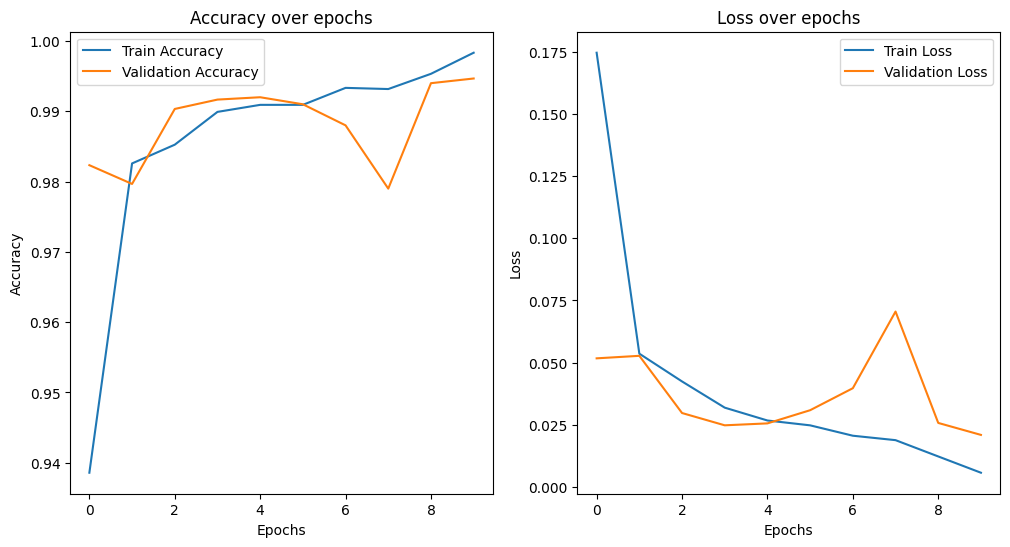

In [21]:
plt.figure(figsize=(12, 6))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Evaluasi dan Visualisasi

In [22]:
model = load_model('best_model.h5')
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\n Test Accuracy: {test_accuracy:.4f}")
print(f" Test Loss: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - accuracy: 0.9958 - loss: 0.0137

 Test Accuracy: 0.9947
 Test Loss: 0.0209


In [23]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = test_generator.classes

class_labels = list(train_generator.class_indices.keys())

94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step


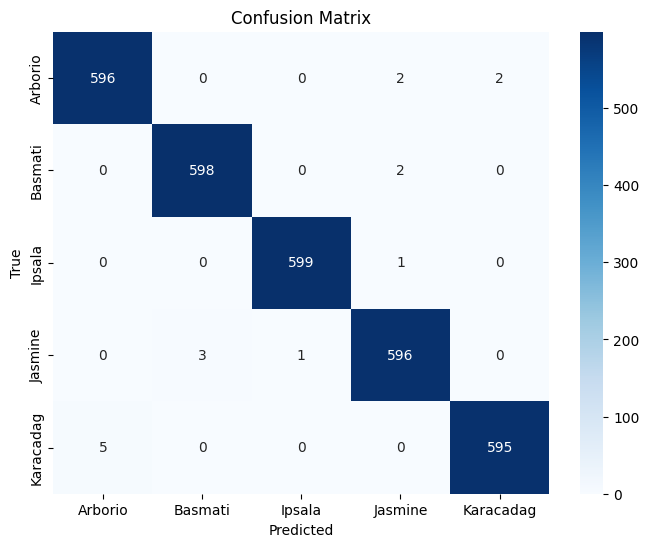

              precision    recall  f1-score   support

     Arborio       0.99      0.99      0.99       600
     Basmati       1.00      1.00      1.00       600
      Ipsala       1.00      1.00      1.00       600
     Jasmine       0.99      0.99      0.99       600
   Karacadag       1.00      0.99      0.99       600

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [24]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

## Konversi Model

In [32]:
#Save the trained model in multiple formats: SavedModel, TFLite, and TFJS
#SavedModel
model.export('/content/drive/MyDrive/saved_model')
# TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/saved_model')
tflite_model = converter.convert()
with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
    f.write(tflite_model)
# TFJS
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/tfjs_model')

Saved artifact at '/content/drive/MyDrive/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139409087539216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409087542096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409087540944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409087542864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409087542672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409087544016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409087543440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409087544592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409087540752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409087545168: TensorSpec(shape=(), dtype=tf.resource, name=Non

failed to lookup keras version from the file,
    this is likely a weight only file


In [36]:
with open('/content/submission/tflite/label.txt', 'w') as f:
    for label in class_names:
        f.write(f"{label}\n")

## Inference (Optional)

Saving Arborio (10008).jpg to Arborio (10008).jpg


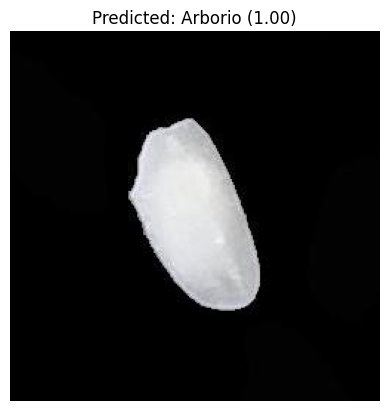

The image is predicted as: Arborio
Confidence score: 1.0000


In [38]:
#Image classification with TFLite model
uploaded = files.upload()
img_path = next(iter(uploaded))
img = Image.open(img_path).resize((250, 250))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0).astype(np.float32)

interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/model.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], img_array)
interpreter.invoke()
pred = interpreter.get_tensor(output_details[0]['index'])
pred_label = np.argmax(pred)

# Replace with your actual class labels
labels = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {labels[pred_label]} ({np.max(pred):.2f})")
plt.show()
print(f"The image is predicted as: {labels[pred_label]}")
print(f"Confidence score: {np.max(pred):.4f}")

Berikut adalah versi kesimpulan dan saran berdasarkan hasil training dan evaluasi model kamu:

---

# 📋 Kesimpulan & Insight

- **Performa Sangat Tinggi dan Konsisten**  
  – Akurasi training mencapai **99.79%**  
  – Akurasi validasi mencapai **99.47%**  
  – Akurasi pada test set (3000 sampel): **99.58%**

- **Metode Training Efektif**  
  – Model disimpan otomatis saat akurasi validasi membaik (ModelCheckpoint)  
  – Pengurangan learning rate otomatis (ReduceLROnPlateau) membantu stabilisasi training  
  – `EarlyStopping` memulihkan bobot terbaik di akhir training

- **Generalisasi Kuat, Overfitting Sangat Rendah**  
  – Loss training: 0.0072 vs. test loss: 0.0209  
  – Performa tetap tinggi meskipun pada data yang belum pernah dilihat model

- **Presisi, Recall, dan F1-Score Konsisten**  
  – Semua kelas memiliki precision, recall, dan f1-score mendekati **1.00**  
  – Tidak ada kelas yang tertinggal (class imbalance minimal)

- **Distribusi Kelas Sangat Merata**  
  – Setiap kelas memiliki 600 sampel pada test set  
  – Hasil menunjukkan bahwa model tidak bias ke kelas tertentu

---

# 💡 Saran & Rekomendasi

1. **Uji Ketahanan di Kondisi Nyata**  
   – Coba uji model dengan gambar dari kamera HP, dalam kondisi pencahayaan rendah/tinggi, atau latar belakang tidak bersih.  
   – Ini penting untuk deployment di lingkungan produksi (misal: aplikasi mobile/web).

2. **Analisis Kesalahan Misprediksi**  
   – Kumpulkan sekitar 30–50 prediksi yang salah (jika ada), dan analisis mengapa kesalahan terjadi (blur, noise, obstruksi).

3. **Model Deployment & Kompresi**  
   – Gunakan hasil ekspor ke **TFLite** untuk Android, atau **TFJS** untuk web.  
   – Terapkan **quantization (int8)** untuk memperkecil ukuran model, mempercepat inferensi di perangkat edge.

4. **Cross-Validation untuk Evaluasi Tambahan**  
   – Jalankan k-fold cross-validation (misal k=5) agar evaluasi model lebih stabil dan tidak tergantung pada satu pembagian data.

5. **Eksperimen Model Lebih Ringan**  
   – Pertimbangkan mengganti backbone CNN dengan **MobileNetV2**, **EfficientNet-Lite**, atau model pruning untuk efisiensi.

6. **Pipeline Monitoring Setelah Deployment**  
   – Setup deteksi otomatis untuk “data drift” (perubahan karakteristik input).  
   – Siapkan rencana retraining secara berkala jika performa menurun.

7. **Sistem Umpan Balik (Feedback Loop)**  
   – Tambahkan fitur pelaporan kesalahan prediksi di UI aplikasi untuk mengumpulkan data baru.  
   – Gunakan laporan ini untuk terus memperbarui dataset dan meningkatkan akurasi dari waktu ke waktu.

---

Jika kamu ingin, saya bisa bantu buatkan template laporan PDF-nya juga. Mau?

In [37]:
from google.colab import files

# Unduh SavedModel (dalam folder)
!zip -r saved_model.zip /content/submission/saved_model
files.download('saved_model.zip')

# Unduh TFLite
files.download('/content/submission/tflite/model.tflite')

# Unduh label.txt
files.download('/content/submission/tflite/label.txt')

# Unduh TFJS model
!zip -r tfjs_model.zip /content/submission/tfjs_model
files.download('tfjs_model.zip')

  adding: content/submission/saved_model/ (stored 0%)
  adding: content/submission/saved_model/fingerprint.pb (stored 0%)
  adding: content/submission/saved_model/assets/ (stored 0%)
  adding: content/submission/saved_model/variables/ (stored 0%)
  adding: content/submission/saved_model/variables/variables.index (deflated 72%)
  adding: content/submission/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/submission/saved_model/saved_model.pb (deflated 88%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  adding: content/submission/tfjs_model/ (stored 0%)
  adding: content/submission/tfjs_model/group1-shard5of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard6of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard13of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard8of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard4of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard9of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard7of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard10of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/model.json (deflated 92%)
  adding: content/submission/tfjs_model/group1-shard12of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard14of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/group1-shard3of15.bin (deflated 7%)
  adding: content/submission/tfjs_model/g

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>